### Stage 1

#### Importing and concatenating the Tables 

In [323]:
# Setting up the environment
import os
import pandas as pd
import numpy as np
import re
import numpy as np
import ast


In [325]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import download
from tqdm import tqdm

In [ ]:
# Folder path where CSV files are located
folder_path = r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\CSV_Selected2"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdiiir(folder_path) if f.endswith('.csv')]

# List to store individual dataframes
dfs = []

# Read each CSV file and append it to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

In [ ]:
dff = final_df
dff.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\SelectedTweetChunks.csv")

In [ ]:
# Verifying if there is any location data
(list(dff["location"].unique()))

In [ ]:
(list(dff.columns))

#### Data Cleaning
Removing unnecessary columns

In [ ]:
# List of columns you want to drop
columns_todrop = ["Unnamed: 0", "type", "username", "url", "media", "retweetedTweet", "retweetedTweetID", "location", "cash_app_handle", "user", 
                 "0", "_type", "in_reply_to_user_id_str.1", "location.1", "cash_app_handle.1", "user.1", "retweetedUserID", "id_str", "replyCount",
                  "retweetCount", "likeCount", "conversationIdStr", "mentionedUsers", "links", "viewCount", "quotedTweet", "in_reply_to_screen_name",
                  "in_reply_to_status_id_str", "in_reply_to_user_id_str", "quoteCount", "conversationId"
                 ]
remaining_columns = [col for col in dff.columns if col not in columns_todrop]
dff[remaining_columns].head()

In [ ]:
# removing unnecessary columns
dff.drop(columns=columns_todrop, axis=1, inplace=True)
# Remove unnecessary columns
dff.head()

In [ ]:
dff.shape

In [ ]:
# Keeping only English Tweets using boolean indexing
dff = dff[dff["lang"] == 'en']
dff.shape

In [ ]:
# Verifying the columns
dff.head()

In [ ]:
# Checking the administrative data
cs = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Raw_Administrative.csv")
cs.head(10)

#### Extracting Location Data from the Tweets

##### Extraction based on "County" or "Co." suffix or prefix

In [ ]:
# Dictionary of US state full names and abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Improved Regex for Counties
def build_location_patterns(cs_df, state_abbreviations):
    counties = cs_df['COUNTY_NAME'].dropna().unique()

    # Prefix variations (handles both uppercase and lowercase)
    prefix_variations = r'(?:County\s+of\s+|county\s+of\s+|Co\.?\s+of\s+|co\.?\s+of\s+)?'

    # Suffix variations (handles uppercase and lowercase)
    suffix_variations = r'(?:\s*(?:County|county|Co\.?|co\.?|Co|co|Cnty|cnty|Cty|cty))?'

    # Combine into a full pattern for each county
    county_pattern = r'\b(' + '|'.join(
        prefix_variations + re.escape(c) + suffix_variations for c in counties
    ) + r')\b'

    # Improved Regex for States
    states = sorted(state_abbreviations.keys(), key=lambda x: -len(x))  # Longest first
    state_names_pattern = r'(?<!\w)(' + '|'.join(re.escape(s) for s in states) + r')(?!\w)'
    state_abbr_pattern = r'\b(' + '|'.join(re.escape(abbr) for abbr in state_abbreviations.values()) + r')\b'

    return re.compile(county_pattern, flags=re.IGNORECASE), \
       re.compile(state_names_pattern, flags=re.IGNORECASE), \
       re.compile(state_abbr_pattern, flags=re.IGNORECASE)


# Match logic: County + State (or abbrev), or just State
def extract_location(text, county_pattern, state_names_pattern, state_abbr_pattern, cs_df, state_abbreviations):
    text_lower = str(text).lower()
    county_match = county_pattern.search(text_lower)
    state_name_match = state_names_pattern.search(text_lower)
    state_abbr_match = state_abbr_pattern.search(text_lower)

    # Match on County + State Name
    if county_match and state_name_match:
        county = county_match.group(0).lower()
        state = state_name_match.group(0).lower()
        match = cs_df[(cs_df['COUNTY_NAME'].str.lower() == county) &
                      (cs_df['STATE_NAME'].str.lower() == state)]
        if not match.empty:
            row = match.iloc[0]
            return row[['COUNTY_NAME', 'STATE_NAME', 'COUNTY_CENTROIDX', 'COUNTY_CENTROIDY',
                        'STATE_CENTROIDX', 'STATE_CENTROIDY']].tolist()

    # Match on County + State Abbreviation
    if county_match and state_abbr_match:
        county = county_match.group(0).lower()
        state_abbr = state_abbr_match.group(0).upper()
        state_name = next((k for k, v in state_abbreviations.items() if v == state_abbr), None)
        if state_name:
            match = cs_df[(cs_df['COUNTY_NAME'].str.lower() == county) &
                          (cs_df['STATE_NAME'].str.lower() == state_name.lower())]
            if not match.empty:
                row = match.iloc[0]
                return row[['COUNTY_NAME', 'STATE_NAME', 'COUNTY_CENTROIDX', 'COUNTY_CENTROIDY',
                            'STATE_CENTROIDX', 'STATE_CENTROIDY']].tolist()

    # Match on just State Name
    if state_name_match:
        state = state_name_match.group(0).lower()
        match = cs_df[cs_df['STATE_NAME'].str.lower() == state]
        if not match.empty:
            row = match.iloc[0]
            return ['NA', row['STATE_NAME'], 'NA', 'NA', row['STATE_CENTROIDX'], row['STATE_CENTROIDY']]

    # Match on just State Abbreviation
    if state_abbr_match:
        state_abbr = state_abbr_match.group(0).upper()
        state_name = next((k for k, v in state_abbreviations.items() if v == state_abbr), None)
        if state_name:
            match = cs_df[cs_df['STATE_NAME'].str.lower() == state_name.lower()]
            if not match.empty:
                row = match.iloc[0]
                return ['NA', row['STATE_NAME'], 'NA', 'NA', row['STATE_CENTROIDX'], row['STATE_CENTROIDY']]

    # No match
    return ['NA'] * 6

# Chunked processing
def process_in_chunks(dff, cs_df, state_abbreviations, chunk_size=10000):
    county_pattern, state_names_pattern, state_abbr_pattern = build_location_patterns(cs_df, state_abbreviations)
    results = []

    for start in tqdm(range(0, len(dff), chunk_size), desc="Processing tweets"):
        end = min(start + chunk_size, len(dff))
        chunk = dff.iloc[start:end].copy()

        loc_data = chunk['text'].apply(
            lambda x: extract_location(x, county_pattern, state_names_pattern, state_abbr_pattern, cs_df, state_abbreviations)
        )
        loc_df = pd.DataFrame(loc_data.tolist(), columns=[
            'COUNTY_NAME', 'STATE_NAME', 'COUNTY_CENTROIDX', 'COUNTY_CENTROIDY',
            'STATE_CENTROIDX', 'STATE_CENTROIDY'
        ])
        chunk = pd.concat([chunk.reset_index(drop=True), loc_df], axis=1)
        results.append(chunk)

    return pd.concat(results, ignore_index=True)


In [ ]:
# Execution of the above codeblock for location extraction
# === Load your datasets ===
dff = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\SelectedTweetChunks.csv")
cs = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Raw_Administrative.csv")

In [ ]:
dff = dff[dff["lang"]=="en"].sample(500000, random_state=11)

In [ ]:
# === Apply threaded processing ===
dff_location = process_in_chunks(dff, cs, state_abbreviations, chunk_size=15000)

In [ ]:
# Exporting the dataset with extracted location
dff_location.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\tweets_locextracted.csv", index=False)

### Stage 2: Location Extracted

#### Import from here

In [ ]:
# Importing the data
loc = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\tweets_locextracted.csv", index_col=False)

In [ ]:
# Removing unnecessary columns
# List of columns you want to drop
columns_todrop = ["Unnamed: 0", "type", "username", "url", "media", "retweetedTweet", "retweetedTweetID", "location", "cash_app_handle", "user", 
                 "0", "_type", "in_reply_to_user_id_str.1", "location.1", "cash_app_handle.1", "user.1", "retweetedUserID", "id_str", "replyCount",
                  "retweetCount", "likeCount", "conversationIdStr", "mentionedUsers", "links", "viewCount", "quotedTweet", "in_reply_to_screen_name",
                  "in_reply_to_status_id_str", "in_reply_to_user_id_str", "quoteCount", "conversationId", "Unnamed: 0.1"
                 ]

'''loc.drop(columns=["Unnamed: 0.2","Unnamed: 0.1","Unnamed: 0","type","media","retweetedTweet","retweetedTweetID","retweetedUserID",
                          "id_str","replyCount","retweetCount","likeCount","quoteCount","conversationId","conversationIdStr","hashtags",
                          "mentionedUsers","links","viewCount","quotedTweet","in_reply_to_screen_name","in_reply_to_status_id_str",
                          "in_reply_to_user_id_str","cash_app_handle","0","_type","in_reply_to_user_id_str.1","location.1","location","cash_app_handle.1",
                          "user.1"], inplace=True) '''

remaining_columns = [col for col in loc.columns if col not in columns_todrop]
# loc[remaining_columns].head()
loc.drop(columns=columns_todrop)

In [ ]:
# Tweets with both county and state location captured
county_state_only = loc[loc["STATE_NAME"].notna() & loc["COUNTY_NAME"].notna()]

In [ ]:
# Tweets with their only state location captured (county+state and state_only)
tweet_location = loc[loc["STATE_NAME"].notna()] 
tweet_location.columns

In [ ]:
coltodrop = ["Unnamed: 0.1", "Unnamed: 0", "type", "url", "media", "retweetedTweet", "retweetedTweetID", "retweetedUserID",
            "id_str", "replyCount", "retweetCount", "likeCount", "quoteCount", "conversationId", "conversationIdStr", "mentionedUsers",
             "links", "viewCount", "quotedTweet", "in_reply_to_screen_name", "in_reply_to_status_id_str", "in_reply_to_user_id_str", "location",
             "cash_app_handle", "user.1","0", "_type", "in_reply_to_user_id_str.1", "location.1", "cash_app_handle.1" ]

In [ ]:
tweet_location.drop(columns=coltodrop, axis=1, inplace=True)

In [ ]:
# Unnecessary columns have been dropped now
tweet_location.shape

In [ ]:
# Exporting the Data
tweet_location.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_Location_Ready.csv", index=False)

### Stage 3: Data ready for Subject Classification

In [293]:
# If already loaded
extweet = tweet_location

In [306]:
# If not loaded
extweet = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_Location_Ready.csv", index_col=False)

In [ ]:
extweet.head()

In [ ]:
extweet.drop(columns= "Unnamed: 0", axis=1, inplace=True)

#### Extracting pure hashtags from list of dictionaries

In [308]:
import ast

for index, hash_str in enumerate(extweet["hashtags"]):
    if isinstance(hash_str, str) and hash_str != "[]":
        extweet.at[index, "hashtags"] = ast.literal_eval(hash_str)

In [313]:
tagholder = []
for index, hash_str in enumerate(extweet["hashtags"]):
    if isinstance(hash_str, list):
        for dict_item in hash_str:
            if isinstance(dict_item, dict) and "text" in dict_item:
                tagholder.append(dict_item["text"])
        extweet.at[index, "hashtags"] = tagholder
    tagholder = []

In [ ]:
extweet[extweet["hashtags"].apply(lambda x: x != "[]" )]["hashtags"]

In [326]:
extweet.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_Location_Hashtag_Ready.csv")

### Stage 4: Text classification for Subject definition (Democrat vs Republican)

In [ ]:
import pandas as pd
extweet.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_Location_Hashtag_Ready.csv", index_col=False)

#### Defining party specific keywords

In [322]:
party_keywords = {
    "Democrat": [
        # Politicians (Federal & State)
        "Kamala", "Harris", "Joe", "Biden", "Pelosi", "Walz", "AOC", "Alexandria Ocasio-Cortez",
        "Gavin Newsom", "Hakeem Jeffries", "Cory Booker", "Elizabeth Warren", "Bernie Sanders",
        "Pete Buttigieg", "Amy Klobuchar", "Stacey Abrams", "Julian Castro", "Gretchen Whitmer",
        "Ro Khanna", "Katie Porter", "Jamie Raskin", "Adam Schiff", "Raphael Warnock", "Jon Ossoff",
        "Maxwell Frost", "Mitch Landrieu", "Andy Beshear", "Josh Shapiro", "Wes Moore",
        "Jeffries", "Schumer", "Durbin", "Brown", "Sinema", "Fetterman", "Kelly", "Rosen",
        "Sherrod Brown", "Maggie Hassan", "Catherine Cortez Masto", "Mark Kelly", "Tina Smith",

        # Influencers & Activists (Progressive)
        "Deja Foxx", "Nabela Noor", "Carlos Eduardo Espina", "Olivia Julianna", "John Russell",
        "Kat Abughazaleh", "Awa Sanneh", "Elizabeth Booker Houston", "Malynda Hale",
        "David Hogg", "Greta Thunberg", "Linda Sarsour", "Shaun King", "Ibram X. Kendi",
        "Rashida Tlaib", "Ilhan Omar", "Ayanna Pressley", "Dolores Huerta", "Gloria Steinem",
        "Robert Reich", "Van Jones", "Michael Moore", "Naomi Klein", "Anand Giridharadas",

        # Celebrities & Endorsers (Liberal)
        "Taylor Swift", "Beyoncé", "Bruce Springsteen", "Cher", "Zendaya", "Sia", "Rosie O'Donnell",
        "Olivia Wilde", "Sophia Bush", "Shailene Woodley", "Ana Navarro", "Arnold Schwarzenegger",
        "Kodak Black", "Nicky Jam", "George Clooney", "Leonardo DiCaprio", "Lady Gaga",
        "Mark Ruffalo", "Kerry Washington", "Jane Fonda", "Robert De Niro", "Barbra Streisand",
        "Stephen Colbert", "Trevor Noah", "John Oliver", "Samantha Bee", "Seth Meyers",

        # Hashtags & Slogans (Progressive & Inclusive)
        "BlueWave", "VoteBlue", "Resist", "TheResistance", "Democrats", "Dems", "TeamKamala",
        "BuildBackBetter", "MedicareForAll", "ClimateAction", "GunControlNow", "BlackLivesMatter",
        "MeToo", "LoveIsLove", "EqualityForAll", "JusticeReform", "GreenNewDeal",
        "BidenHarris", "DemocracyIsOnTheBallot", "WomensRightsAreHumanRights", "VoteThemOut",
        "ProtectOurKids", "StopTheBans", "KeepOurRights", "ClimateCrisis", "DefendDemocracy",
        "BlueStates", "BlueCities", "VoteForChange", "HealthcareIsAHumanRight", "EndGunViolence",
        "SaveOurPlanet", "FutureIsFemale", "NoBanNoWall", "ScienceIsReal", "TransRights",
        "VoterRights", "ExpandTheCourt", "TaxTheBillionaires", "CancelStudentDebt", "InvestInOurFuture",
        "UniteBlue", "StrongerTogether", "ForThePeople", "OurRightsOurFuture", "PowerToThePolls",

        # Policies & Agendas (Social & Economic Justice)
        "Affordable Care Act", "Medicare for All", "Green New Deal", "Climate Change", "Gun Control",
        "LGBTQ+ Rights", "Reproductive Rights", "Voting Rights", "Student Loan Forgiveness",
        "Universal Pre-K", "Paid Family Leave", "Minimum Wage Increase", "Police Reform",
        "Criminal Justice Reform", "Immigration Reform", "DACA", "Net Neutrality", "Renewable Energy",
        "Tax the Rich", "Wealth Tax", "Universal Healthcare", "Public Option", "Social Justice",
        "Economic Equality", "Environmental Protection", "Child Tax Credit", "Affordable Housing",
        "Racial Justice", "Equity", "TransRightsAreHumanRights", "ProtectOurDemocracy", "CombatInflation",
        "InfrastructureBill", "InflationReductionAct", "StrengthenUnions", "ExpandAccessToHealthcare",
        "DefendChoice", "CodifyRoeVWade", "AddressSystemicRacism", "ProtectVotingRights", "InvestInEducation",
        "SupportSmallBusinesses", "FightForOurFuture", "EndCitizensUnited", "CampaignFinanceReform",
        "ExpandSocialSecurity", "LowerPrescriptionCosts", "InvestInCleanEnergy", "ProtectPublicLands",
        "SupportFarmers", "PromoteFairTrade", "EndGunViolenceEpidemic", "ProtectOurChildren",
        "ExpandBackgroundChecks", "RaiseTheWage", "WorkersRights", "AffordableChildcare", "FreeCollege",

        # Demographics & Coalitions
        "YoungVoters", "BlackVoters", "LatinxVote", "AsianAmericanVote", "WomenVote", "UnionMembers",
        "ProgressiveCaucus", "NewDemocratCoalition", "CongressionalBlackCaucus", "HispanicCaucus",
        "LGBTQCaucus", "EnvironmentalCaucus",

        # Media & News Outlets (Liberal-leaning)
        "MSNBC", "CNN", "TheNewYorkTimes", "TheWashingtonPost", "NPR", "Vox", "TheNation",
        "MotherJones", "DemocracyNow", "TheDailyShow",
    ],
    "Republican": [
        # Politicians (Federal & State)
        "Donald Trump", "Trump", "Ron DeSantis", "Nikki Haley", "Tim Scott", "Vivek Ramaswamy",
        "Mike Pence", "Kristi Noem", "Greg Abbott", "Ted Cruz", "Josh Hawley", "Marjorie Taylor Greene",
        "Lauren Boebert", "Jim Jordan", "Matt Gaetz", "Elise Stefanik", "J.D. Vance", "RFK Jr.",
        "Mike Johnson", "Steve Scalise", "Tom Cotton", "Rick Scott", "Marco Rubio", "Lindsey Graham",
        "Doug Burgum", "Kevin McCarthy", "Byron Donalds", "Jim Banks", "Ted Budd",
        "Ted Budd", "Mitch McConnell", "John Thune", "John Cornyn", "Tom Emmer", "Jim Comer",
        "Kevin Cramer", "Cynthia Lummis", "Tommy Tuberville", "Rand Paul",

        # Influencers & Activists (Conservative)
        "Charlie Kirk", "Candace Owens", "Ben Shapiro", "Tucker Carlson", "Dan Bongino", "Sean Hannity",
        "Laura Ingraham", "Mark Levin", "Steven Crowder", "Matt Walsh", "Jesse Watters", "Glenn Beck",
        "Jack Posobiec", "James O'Keefe", "Sebastian Gorka", "Alex Jones", "Richard Grenell",
        "Andy Ngo", "Jordan Peterson", "Dennis Prager", "Dave Rubin", "Michael Knowles",
        "James Lindsay", "Jack Hibbs", "Seth Dillon",

        # Celebrities & Endorsers (Conservative)
        "Elon Musk", "Kid Rock", "Hulk Hogan", "Waka Flocka", "Amber Rose", "Zachary Levi",
        "Brittany Mahomes", "James Woods", "Scott Baio", "Kanye West", "Roseanne Barr", "Jon Voight",
        "Dana White", "Travis Tritt", "Antonio Sabato Jr.", "Kevin Sorbo",
        "Dennis Quaid", "Isaiah Washington", "Kristy Swanson", "Dean Cain", "Kevin Sorbo",
        "Ted Nugent", "Scott Stapp", "Ricky Schroder",

        # Hashtags & Slogans (Conservative & Nationalist)
        "MAGA", "Trump2024", "SaveAmerica", "AmericaFirst", "DrainTheSwamp", "KAG",
        "KeepAmericaGreat", "WalkAway", "BackTheBlue", "2A", "ProLife", "StopTheSteal",
        "ElectionIntegrity", "BuildTheWall", "SecureTheBorder", "LawAndOrder", "Patriot",
        "Conservative", "Republicans", "GOP", "RedWave", "TrumpTrain", "MAGA2024",
        "DeSantis2024", "Haley2024", "TakeBackAmerica", "LetsGoBrandon", "NoMoreBiden",
        "StopTheWoke", "ParentalRights", "FreedomOverFauci", "SocialismSucks", "RedStates",
        "RedCities", "SaveOurChildren", "DefendOurBorders", "ConstitutionMatters",
        "FakeNews", "DeepState", "SilentMajority", "LiberalTears", "StopTheCheat",
        "OpenTheBooks", "BidenCrimeFamily", "HunterBiden", "BigTechCensorship", "GlobalistAgenda",
        "AmericaOrBust", "GodGunsAndTrump", "WokeMindVirus", "SaveOurSchools", "NoToMandates",
        "StopTheSteal2", "TrustThePlan", "WWG1WGA", "HoldTheLine", "FightForFreedom",

        # Policies & Agendas (Fiscal & Social Conservatism)
        "Second Amendment", "Pro-Life", "Border Security", "Tax Cuts", "Deregulation", "Gun Rights",
        "Religious Freedom", "Election Integrity", "School Choice", "Energy Independence",
        "America First", "Law and Order", "Strong Military", "Traditional Values", "Free Market",
        "Limited Government", "Lower Taxes", "Strong Borders", "Immigration Reform", "Anti-CRT",
        "Parental Rights", "Voter ID Laws", "Economic Freedom", "National Security", "Patriotism",
        "StopCriticalRaceTheory", "ProtectOurKids", "SecureTheBorder", "DefendTheSecondAmendment",
        "PromoteSchoolChoice", "CutSpending", "FightInflation", "RestoreAmericanValues",
        "OpposeVaccineMandates", "DefendReligiousLiberty", "ReduceGovernmentRegulation",
        "ProtectOurElections", "SupportLawEnforcement", "EnergyDominance", "EndWokePolicies",
        "SecureOurFuture", "DefundTheFBI", "StopTheRadicalLeft", "ProtectOurVeterans",
        "FiscalResponsibility", "ConstitutionalCarry", "Originalism", "Textualism",
        "EndIllegalImmigration", "ProtectOurSovereignty", "FreeSpeech", "StopBigGovernment",
        "BalancedBudget", "TermLimits", "StatesRights", "Deregulation", "FreeMarketHealthcare",

        # Demographics & Coalitions
        "EvangelicalVote", "RuralVoters", "SmallBusinessOwners", "ConservativeWomen", "VeteransForTrump",
        "FreedomCaucus", "RepublicanStudyCommittee", "TeaPartyMovement", "SecondAmendmentCaucus",
        "ValuesVoters",

        # Media & News Outlets (Conservative-leaning)
        "FoxNews", "Newsmax", "OANN", "Breitbart", "TheDailyWire", "TheBlaze", "Townhall",
        "WashingtonTimes", "TheFederalist", "SalemRadio",
    ]
}

#### Defining Tweet Subjects from Party Keywords

In [327]:
import numpy as np
import ast
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import download
from tqdm import tqdm

# Download necessary NLTK resources
download('wordnet')
download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# STEP 1: Make sure 'hashtags' is in list format
def ensure_list(hashtag_str):
    if isinstance(hashtag_str, list):
        return hashtag_str
    try:
        return ast.literal_eval(hashtag_str)
    except Exception:
        return []

# STEP 2: Lemmatize a text or hashtag
def lemmatize_words(text):
    # Lowercase, remove special characters, split, lemmatize each word
    words = re.findall(r'\w+', text.lower())
    return [lemmatizer.lemmatize(word) for word in words]

# STEP 3: Classification Function
def classify_tweet(content, hashtags, party_keywords):
    # Combine and lemmatize content and hashtags
    all_words = lemmatize_words(content)
    for tag in hashtags:
        all_words += lemmatize_words(tag)

    # Convert to set for fast lookup
    word_set = set(all_words)

    # Count matches
    dem_matches = any(kw.lower() in word_set for kw in party_keywords["Democrat"])
    rep_matches = any(kw.lower() in word_set for kw in party_keywords["Republican"])

    # Decide subject
    if dem_matches and not rep_matches:
        return "Democrat"
    elif rep_matches and not dem_matches:
        return "Republican"
    else:
        return np.nan  # Mixed or no clear match

# STEP 4: Apply on your DataFrame with tqdm progress bar
tqdm.pandas(desc="Classifying Tweets")

extweet["hashtags"] = extweet["hashtags"].apply(ensure_list)
extweet["subject"] = extweet.progress_apply(
    lambda row: classify_tweet(row["text"], row["hashtags"], party_keywords),
    axis=1
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rhitwik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Rhitwik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Classifying Tweets: 100%|██████████| 227112/227112 [01:37<00:00, 2319.59it/s]


In [341]:
pd.set_option('display.max_colwidth', None)

In [ ]:
extweet[["text", "subject"]].sample(50)

#### Subject has been defined based on hashtags and rawContent

#### Machine Learning Training and Deployment for defining the missing tweet subjects (Where hashtags were missing) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Initialize tqdm for progress tracking
tqdm.pandas(desc="Processing Rows")

# STEP 1: Preprocess and clean data
# Combine 'rawContent' and 'hashtags' into one field for feature extraction
extweet['combined_features'] = extweet['rawContent'] + " " + extweet['hashtags'].apply(lambda x: " ".join(x))

# STEP 2: Prepare training data
# Remove rows with NaN subject (invalid rows)
train_data = extweet.dropna(subset=["subject"])

# Features and labels
X = train_data['combined_features']  # Text data
y = train_data['subject']  # Labels (Democrat / Republican)

# STEP 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 4: Build a pipeline with TF-IDF vectorization and Logistic Regression
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# STEP 5: Train the model
model.fit(X_train, y_train)

# STEP 6: Make predictions on the test set
y_pred = model.predict(X_test)

# STEP 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# STEP 8: Optional - Cross-validation (for better evaluation)
cross_val = cross_val_score(model, X, y, cv=5)
print(f'Cross-validation accuracy: {cross_val.mean() * 100:.2f}%')

# STEP 9: Predict 'subject' for the missing rows in the original 'extweet' dataframe
# Filter rows with missing subject
missing_subjects = extweet[extweet['subject'].isna()]

# STEP 10: Predict for missing rows with tqdm progress tracking
def predict_subject_for_missing_rows(row):
    # Extract features and predict the subject (Democrat or Republican)
    content = row['rawContent']
    hashtags = row['hashtags']
    combined = content + " " + " ".join(hashtags)
    return model.predict([combined])[0]  # Predict and return the label

# Apply the prediction function with progress bar
extweet.loc[extweet['subject'].isna(), 'subject'] = missing_subjects.progress_apply(predict_subject_for_missing_rows, axis=1)

# STEP 11: Check the final DataFrame
print(f"\nFinal DataFrame with 'subject' column populated: {extweet['subject'].isna().sum()} missing values")

In [344]:
# Import core libraries for model building
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import re

# Initialize tqdm to show progress bars on DataFrame operations
tqdm.pandas(desc="Processing Rows")

# STEP 1: Define a text cleaning function
# This function will remove URLs, mentions, hash symbols, and extra whitespace
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))            # Remove URLs
    text = re.sub(r"@\w+", "", text)                    # Remove Twitter handles
    text = re.sub(r"#", "", text)                       # Remove '#' but retain the word
    text = re.sub(r"\s+", " ", text).strip()            # Normalize whitespace
    return text

# STEP 2: Apply the text cleaning to the 'text' column
extweet['text'] = extweet['text'].astype(str).apply(clean_text)

# STEP 3: Combine 'text' and 'hashtags' for richer feature representation
# Hashtags are joined into a single string, appended to cleaned content
extweet['combined_features'] = extweet['text'] + " " + extweet['hashtags'].apply(lambda x: " ".join(x))

# STEP 4: Prepare the training data
# Remove rows where the label 'subject' is missing
train_data = extweet.dropna(subset=["subject"])

# Separate features and labels
X = train_data['combined_features']  # Text input
y = train_data['subject']            # Class label: Democrat or Republican

# STEP 5: Check for class imbalance
# Display count of each label to decide whether balancing is needed
print("\nClass Distribution:\n", y.value_counts())

# STEP 6: Split the data into training and testing sets
# 80% training, 20% testing, fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# STEP 7: Build a Machine Learning Pipeline
# Includes TF-IDF vectorization and Logistic Regression classifier
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',        # Remove common English stopwords
        max_features=10000,          # Limit vocab size to top 10,000 terms
        ngram_range=(1, 2),          # Use both unigrams and bigrams
        min_df=5,                    # Ignore words in fewer than 5 docs
        max_df=0.9                   # Ignore overly common words
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',     # Automatically adjust weights for imbalanced classes
        random_state=42
    ))
])

# STEP 8: Train the model on training data
model.fit(X_train, y_train)

# STEP 9: Make predictions on the test set
y_pred = model.predict(X_test)

# STEP 10: Evaluate model performance using accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy on test set: {accuracy * 100:.2f}%')
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# STEP 11: Cross-validation for generalization check
cross_val = cross_val_score(model, X, y, cv=5)
print(f'\nCross-validation accuracy: {cross_val.mean() * 100:.2f}%')

# STEP 13: Predict 'subject' for the missing rows in the original DataFrame
# Reuse the same text cleaning and feature combining logic for consistency
def predict_subject_for_missing_rows(row):
    content = clean_text(row['text'])
    hashtags = " ".join(row['hashtags'])
    combined = content + " " + hashtags
    return model.predict([combined])[0]  # Predict class label

# Apply prediction function with tqdm progress bar
extweet.loc[extweet['subject'].isna(), 'subject'] = extweet[extweet['subject'].isna()].progress_apply(
    predict_subject_for_missing_rows, axis=1
)

# STEP 14: Final check for remaining missing values in the 'subject' column
print(f"\nFinal DataFrame check: {extweet['subject'].isna().sum()} missing values remaining.")


Class Distribution:
 subject
Republican    77783
Democrat      77546
Name: count, dtype: int64

Accuracy on test set: 99.71%

Classification Report:

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     15503
  Republican       1.00      1.00      1.00     15563

    accuracy                           1.00     31066
   macro avg       1.00      1.00      1.00     31066
weighted avg       1.00      1.00      1.00     31066


Cross-validation accuracy: 99.75%


Processing Rows: 100%|██████████| 71783/71783 [01:34<00:00, 759.50it/s]


Final DataFrame check: 0 missing values remaining.


In [ ]:
extweet[["subject","text", "hashtags"]].sample(50)

In [348]:
extweet.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_PartyClassified_.csv", index=False)

In [ ]:
extweet = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_PartyClassified_.csv", index_col=False)

### Stage 5: Sentiment Analysis

In [ ]:
extweet = pd.read_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\Tweet_PartyClassified_.csv", index_col=False)

#### Sentiment Analysis on Classified (Tweet Subject) Tweets

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rhitwik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 227112/227112 [03:01<00:00, 1248.75it/s]


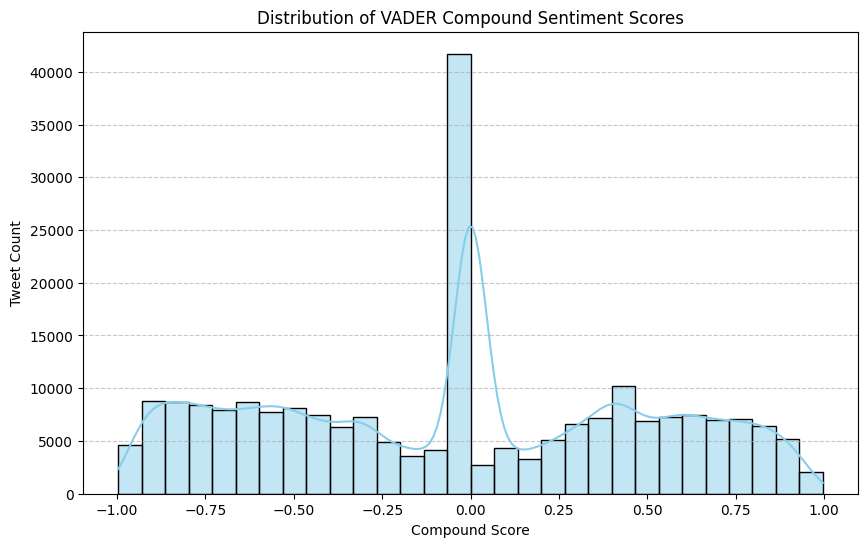

In [388]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas()

# STEP 1: Download the VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# STEP 2: Initialize the VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Adding custom lexicon for political sentiment analysis
custom_political_lexicon = {
    # Positive Sentiment Terms
    "visionary": 2.5,
    "decisive": 2.0,
    "principled": 2.0,
    "transparent": 1.8,
    "competent": 2.2,
    "experienced": 1.9,
    "charismatic": 2.3,
    "respected": 2.1,
    "bipartisan": 1.7,
    "inclusive": 1.8,
    "progressive": 1.5,
    "forward-thinking": 2.0,
    "collaborative": 1.6,
    "nation-building": 1.9,
    "hopeful": 1.7,
    "economic growth": 2.4,
    "job creation": 2.3,
    "tax relief": 1.8,
    "healthcare reform": 1.9,
    "strong defense": 2.0,
    "education funding": 1.7,
    "climate action": 1.6,
    "unity": 2.0,
    "leadership": 2.2,
    "integrity": 2.5,
    "patriot": 2.0,
    "patriotic": 2.1,
    "freedom": 2.3,
    "liberty": 2.2,
    "justice": 2.4,
    "equality": 2.1,
    "democracy": 2.5,

    # Negative Sentiment Terms
    "indicted": -2.5,
    "convicted": -2.7,
    "fraud": -2.8,
    "corrupt": -3.0,
    "bribery": -2.6,
    "cover-up": -2.4,
    "impeachment": -2.2,
    "resign": -1.9,
    "criminal": -3.0,
    "investigation": -1.8,
    "radical": -2.0,
    "extremist": -2.5,
    "traitor": -3.2,
    "unfit": -2.1,
    "liar": -2.9,
    "hypocrite": -2.6,
    "disgrace": -2.7,
    "authoritarian": -2.8,
    "dictator": -3.0,
    "bigot": -2.9,
    "job-killing": -2.3,
    "tax hike": -2.0,
    "inflation": -2.5,
    "recession": -2.7,
    "debt crisis": -2.6,
    "open borders": -2.2,
    "weak leadership": -2.4,
    "failed policy": -2.3,
    "scandal": -2.8,
    "coverup": -2.5,
    "nepotism": -2.6,
    "cronyism": -2.7,
    "mismanagement": -2.4,
    "incompetent": -2.9,
    "divisive": -2.2,
    "polarizing": -2.1,
    "suppression": -2.5,
    "oppression": -2.6,
    "censorship": -2.3,
    "propaganda": -2.4,
    "disinformation": -2.5,
    "fake news": -2.7,
    "witch hunt": -2.6,
    "rigged": -2.8,
    "stolen election": -3.0,
    "deep state": -2.9,
    "swamp": -2.7,
    "elitist": -2.0,
    "globalist": -2.1,
    "socialist": -2.2,
    "communist": -2.5,
    "fascist": -3.0,
    "nazi": -3.2,
    "racist": -3.0,
    "sexist": -2.8,
    "homophobic": -2.7,
    "xenophobic": -2.6,
    "misogynist": -2.9,
    "white supremacist": -3.1,
    "terrorist": -3.0,
    "insurrection": -2.9,
    "coup": -3.0,
    "treason": -3.2,
    "sedition": -3.1,
    "hate speech": -2.8,
    "violence": -2.9,
    "riots": -2.7,
    "looting": -2.6,
    "anarchy": -2.5,
    "chaos": -2.4,
    "lawlessness": -2.3,
    "authoritarianism": -2.8,
    "dictatorship": -3.0,
    "totalitarian": -3.1,
    "oppressive": -2.6,
    "surveillance": -2.2,
    "martial law": -2.5,
    "police state": -2.7,
    "coup d'état": -3.0,
    "civil war": -3.2,
    "genocide": -3.5,
    "ethnic cleansing": -3.4,
    "war crimes": -3.3,
    "human rights violation": -3.2,
    "torture": -3.1,
    "detention": -2.4,
    "extrajudicial": -2.5,
    "black site": -2.6,
    "rendition": -2.7,
    "espionage": -2.8,
    "treachery": -2.9,
    "betrayal": -2.6,
    "backstabbing": -2.5,
    "deceit": -2.7,
    "manipulation": -2.4,
    "brainwashing": -2.6,
    "indoctrination": -2.5,
    "cult": -2.3,
    "fanatic": -2.2,
    "zealot": -2.1,
    "extremism": -2.4,
    "militant": -2.3,
    "radicalism": -2.5,
    "terrorism": -3.0,
    "jihad": -2.9,
    "martyrdom": -2.8,
    "suicide bomber": -3.2,
    "massacre": -3.3,
    "bloodshed": -3.0,
    "slaughter": -3.1}
 
sia.lexicon.update(custom_political_lexicon)

# STEP 3: Function to calculate sentiment and compound score with adjusted thresholds
def get_sentiment_and_compound_score(text):
    # Using the polarity_scores method from SentimentIntensityAnalyzer
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    # Assign a sentiment label based on adjusted compound score thresholds
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral' 
    
    return sentiment, compound_score

# STEP 4: Apply sentiment analysis to 'rawContent' and create new columns for 'sentiment' and 'compound_score'
extweet[['sentiment', 'compound_score']] = extweet['rawContent'].progress_apply(
    lambda x: pd.Series(get_sentiment_and_compound_score(x))
)

# STEP 5: Plot the distribution of compound sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(extweet['compound_score'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of VADER Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Tweet Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [385]:
extweet[extweet["subject"].apply(lambda x: x != "Republican")][["subject", "sentiment", "compound_score", "text", "STATE_NAME"]].shape

(107312, 5)

In [354]:
extweet.to_csv(r"D:\UCD\Geostatistics\Project\usc-x-24-us-election-main\Output2\SentimentAnalysis_Final.csv", index=False)

In [400]:
extweet.groupby(["STATE_NAME", "subject"])["sentiment"].value_counts()

STATE_NAME      subject     sentiment
Alabama         Democrat    negative       140
                            positive        86
                            neutral         52
                Republican  positive       117
                            negative       116
                            neutral         48
Alaska          Democrat    positive        20
                            negative        17
                            neutral          9
                Republican  positive        42
                            negative        29
                            neutral         14
Arizona         Democrat    positive       114
                            negative        99
                            neutral         63
                Republican  positive       315
                            negative       202
                            neutral        131
Arkansas        Democrat    negative        17
                            positive         9
                      

In [401]:
aggregation = extweet.groupby(["STATE_NAME", "subject"])["sentiment"].value_counts().reset_index()
positive = aggregation[aggregation["sentiment"]=="positive"]

In [402]:
max_counts = positive.groupby("STATE_NAME")['count'].transform('max')
winners = positive[positive['count']==max_counts]
winners["STATE_CENTROIDX"] = extweet["STATE_CENTROIDX"]
winners["STATE_CENTROIDY"] = extweet["STATE_CENTROIDY"]
winners

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_21808\2277137434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners["STATE_CENTROIDX"] = extweet["STATE_CENTROIDX"]
C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_21808\2277137434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners["STATE_CENTROIDY"] = extweet["STATE_CENTROIDY"]


,STATE_NAME,subject,sentiment,count,STATE_CENTROIDX,STATE_CENTROIDY
3,Alabama,Republican,positive,117,-86.275656,39.908071
9,Alaska,Republican,positive,42,-86.275656,39.908071
15,Arizona,Republican,positive,315,-120.555388,43.936647
21,Arkansas,Republican,positive,33,-105.547815,38.998546
28,California,Republican,positive,315,-86.275656,39.908071
33,Colorado,Republican,positive,13804,-105.547815,38.998546
40,Connecticut,Republican,positive,17,-120.555388,43.936647
46,Florida,Republican,positive,457,-86.275656,39.908071
52,Georgia,Republican,positive,201,-86.275656,39.908071
57,Hawaii,Republican,positive,149,-86.275656,39.908071


In [ ]:
winners.to_csv(r"D:\UCD\Geostatistics\Project\Output2\usc-x-24-us-election-main\Results_final.csv", index=None)